## **Problem Set 2: Constrained Dynamics and Variational Integrators**

#### **Problem №1: Closed Loop Chain**

Consider the following system:

<p align="center">
<img src="images/closed_loop.png" alt="drawing" width="100%" style="margin:auto"/>
</p>


with parameters given by:

In [1]:
m1 = 0.5  # [kg] - mass in the first joint
m2 = 0.7  # [kg] - mass in the first joint
l = 0.3  # [m] - the length of links
L = 0.4  # [m]
g = 9.81  # [m/s^2] the gravitational acceleration

Do the following:

* **[5 points]** Choose the coordinates to represent the dynamics of your system, derive the free dynamics in this coordinates (you may use Euler-Lagrange or just Newton laws), write the set of holonomic constraints that represent the closed chain in form $\boldsymbol{\varphi}(\mathbf{q}) = 0$. Find the constraint Jacobian $\mathbf{J} = \frac{\partial\boldsymbol{\varphi}}{\partial\mathbf{q}}$ and it's derivative $\dot{\mathbf{J}}$ as function of $\mathbf{q}$ and $\dot{\mathbf{q}}$

* **[15 points]** Use either Lagrange or Udwadia-Kalaba approach with Runge-Kutta 4-th order integrator to simulate the motion of the system provided sample rate $dT = 0.01$ and feasible initial point $\mathbf{q}(0)$ in the rest. Calculate and plot the constraints penalization along the simulated trajectory $\|\boldsymbol{\varphi}(\mathbf{q}(t))\|$. Introduce and tune the Baumgarte stabilization technique to reduce constraint penalization. Animate the motion. 

* **[15 points]** Introduce the external torques $u_{1,2} = 3\sin(t)$ in to the static joints, repeat the steps above. 

---

## Derivation

Mass matrix:

$$
M(\mathbf{q}) =
l^2 \begin{bmatrix}
m_1 & 0 \\
0 & m_2
\end{bmatrix}
$$

Non-acceleration term (only gravitational gradient remains):

$$
h(\mathbf{q}, \mathbf{\dot{q}}) =
gl \begin{bmatrix}
m_1 \cos q_1\\
m_2 \cos q_2
\end{bmatrix}
$$

Constraint:

$$
\varphi(\mathbf{q}) =
(l[\cos q_1 - \cos q_2] - L)^2 +
l^2(\sin q_1 - \sin q_2)^2 - l^2 =
L^2 + l^2 - 2Ll (\cos q_1 - \cos q_2) - 2 l^2 \cos (q_1 - q_2)
$$

Thus,

$$
J(\mathbf{q}) = \frac{\partial \varphi}{\partial \mathbf{q}} =
2 l \begin{bmatrix}
L \sin q_1 + l \sin (q_1 - q_2) \\
- L \sin q_2 - l \sin (q_1 - q_2)
\end{bmatrix}^T, \:

\dot{J}(\mathbf{q}, \mathbf{\dot{q}}) =
2 l \begin{bmatrix}
L \dot{q}_1 \cos q_1 + l (\dot{q}_1 - \dot{q}_2) \cos (q_1 - q_2) \\
- L \dot{q}_2 \cos q_2 - l (\dot{q}_1 - \dot{q}_2) \cos (q_1 - q_2)
\end{bmatrix}^T, \:
$$

Final equation:

$$
\begin{bmatrix}
M & J^T \\
J & 0
\end{bmatrix}
\begin{bmatrix}
\mathbf{\ddot{q}} \\ \mathbf{\lambda}
\end{bmatrix} =
\begin{bmatrix}
Q - h \\ -\dot{J} \mathbf{\dot{q}}
\end{bmatrix} =
\begin{bmatrix}
Q - h \\ -\dot{J} \mathbf{\dot{q}} - 2 \omega J \mathbf{\dot{q}} - \omega^2 \varphi
\end{bmatrix} \: (\text{with Baumgarte stabilization})
$$

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
from matplotlib import animation
from collections import deque
from typing import Tuple, Callable, Optional

matplotlib.rcParams['animation.embed_limit'] = 128
np.set_printoptions(precision=6, suppress=True)

In [3]:
def phi(q: np.ndarray) -> float:
    q_1, q_2 = q
    return L ** 2 + l ** 2 - \
        2 * L * l * (np.cos(q_1) - np.cos(q_2)) - \
        2 * (l ** 2) * np.cos(q_1 - q_2)


def energy_1(q: np.ndarray, dot_q: np.ndarray) -> float:
    q_1, q_2 = q
    dq_1, dq_2 = dot_q
    return 0.5 * m1 * (l * dq_1) ** 2 + \
        0.5 * m2 * (l * dq_2) ** 2 + \
        g * l * (m1 * np.sin(q_1) + m2 * np.sin(q_2))


def get_h(q: np.ndarray) -> np.ndarray:
    q_1, q_2 = q
    return g * l * np.array(
        [m1 * np.cos(q_1), m2 * np.cos(q_2)]
    )


def get_jac_phi(q: np.ndarray) -> np.ndarray:
    q_1, q_2 = q
    return 2 * l * np.array(
        [[
            L * np.sin(q_1) + l * np.sin(q_1 - q_2),
            - L * np.sin(q_2) - l * np.sin(q_1 - q_2)
        ]]
    )


def get_dot_jac_phi(q: np.ndarray, dot_q: np.ndarray) -> np.ndarray:
    q_1, q_2 = q
    dq_1, dq_2 = dot_q
    return 2 * l * np.array(
        [[
            L * dq_1 * np.cos(q_1) + l * (dq_1 - dq_2) * np.cos(q_1 - q_2),
            -L * dq_2 * np.cos(q_2) - l * (dq_1 - dq_2) * np.cos(q_1 - q_2),
        ]]
    )


def shur_compliment(q: np.ndarray) -> np.ndarray:
    jac_phi = get_jac_phi(q)
    res = np.zeros((3, 3))
    res[0][0] = m1 * l ** 2
    res[1][1] = m2 * l ** 2
    res[2:, :2] = jac_phi
    res[:2, 2:] = jac_phi.T
    return res

In [4]:
def visualize_n_pendulum(
        points: Tuple[np.ndarray, ...],
        title: str,
        stats=None,
        dt=0.01,
        trace_len=0.1,
        axes=False,
        show=True
):
    length = len(min(points, key=len))
    l_max = 0

    for i in range(1, len(points)):
        l_max = max(2.5 * np.linalg.norm(points[i][0] - points[i - 1][0]), l_max)

    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(autoscale_on=False,
                         xlim=(-l_max, l_max), ylim=(-l_max, l_max))
    ax.set_aspect('equal', adjustable='box')

    if axes:
        ax.grid(color='black', linestyle='--', linewidth=0.8, alpha=0.5)
    else:
        plt.axis('off')

    lines = ax.plot([], [], '-', c='black', lw=2)[0]
    circles = [ax.plot([], [], 'o', c='blue', markersize=6, zorder=5)[0] for _ in range(len(points))]
    traces = [ax.plot([], [], '-', c='blue', lw=1, alpha=0.2)[0] for _ in range(len(points))]

    corner_text = ax.text(0.05, 0.8, '', transform=ax.transAxes, zorder=10)
    histories_x = [deque(maxlen=int(trace_len * length)) for _ in range(len(points))]
    histories_y = [deque(maxlen=int(trace_len * length)) for _ in range(len(points))]

    def animate(idx):
        stat_text = ''
        these_x = [
            points[j][idx][0] for j in range(len(points))
        ]
        these_y = [
            points[j][idx][1] for j in range(len(points))
        ]

        if idx == 0:
            for _h in histories_x:
                _h.clear()
            for _h in histories_y:
                _h.clear()

        for j, _h in enumerate(histories_x):
            _h.appendleft(points[j][idx][0])
        for j, _h in enumerate(histories_y):
            _h.appendleft(points[j][idx][1])

        lines.set_data(these_x, these_y)
        for j, _c in enumerate(circles):
            _c.set_data([points[j][idx][0]], [points[j][idx][1]])
        for j, _t in enumerate(traces):
            _t.set_data(histories_x[j], histories_y[j])

        if stats is not None:
            for stat in stats:
                stat_text += rf'{stat[0]}:  {stat[1][idx]:.3f}'
                stat_text += '\n'
            corner_text.set_text(stat_text)

        return *circles, lines, *traces, corner_text

    ani = animation.FuncAnimation(
        fig, animate, interval=dt, frames=length, blit=True
    )

    with open(f'{title}.html', 'w') as f:
        f.write(ani.to_jshtml())

    if show:
        plt.show()

    return ani


def plot_res_task_1(result: np.ndarray, title: str, t_span: np.ndarray):
    qs = result[:, :2]
    phis = np.array([np.abs(phi(_q)) for _q in result[:, :2]])
    energies = np.array([energy_1(x[:2], x[2:]) for x in result])

    points = \
        np.zeros(qs.shape), \
            l * np.c_[np.cos(qs[:, 0]), np.sin(qs[:, 0])], \
            l * np.c_[np.cos(qs[:, 1]), np.sin(qs[:, 1])] + np.array([L, 0]), \
            np.zeros(qs.shape) + np.array([L, 0])

    stats = [
        [r'time $t$ ', t_span],
        [r'$|\varphi(\mathbf{q})|$', phis],
        [r'$E(t)$', energies]
    ]

    plt.title(r'$|\varphi(\mathbf{q})|$')
    plt.plot(t_span, phis, label=r'$|\varphi(\mathbf{q})|$')
    plt.xlabel('$t,s$')
    plt.legend(loc='best')
    plt.show()

    visualize_n_pendulum(
        points, title,
        stats=stats,
        axes=False,
        show=True,
        trace_len=0.2,
        dt=DT * 1000
    )

In [5]:
def state_1(t: float, x: np.ndarray,
            q_ext: Optional[Callable[[float], np.ndarray]] = None,
            omega: float = 0) -> np.ndarray:
    q = x[:2]
    dot_q = x[2:]

    shur = shur_compliment(q)
    inv_shur = np.linalg.inv(shur)
    dot_j = get_dot_jac_phi(q, dot_q)
    j_phi = get_jac_phi(q)
    h_val = get_h(q)

    if q_ext:
        q_val = q_ext(t)
    else:
        q_val = np.zeros(h_val.shape)

    return np.r_[
        dot_q,
        inv_shur.dot(
            np.r_[
                q_val - h_val,
                -dot_j.dot(dot_q) - 2 * omega * j_phi.dot(dot_q) - (omega ** 2) * phi(q)
            ]
        )[:2]
    ]


def q_external(t: float) -> np.ndarray:
    return 3 * np.array([np.sin(t), np.sin(t)])

In [6]:
T_END = 10
DT = 0.01
T_SPAN = np.arange(0, T_END, DT)
X_0 = np.array(
    [
        np.arccos((3 * l ** 2 + L ** 2) / (4 * L * l)),
        np.arccos((3 * l ** 2 + L ** 2) / (4 * L * l)) +
        np.arccos((5 * l ** 2 - L ** 2) / (4 * l ** 2)),
        0, 0
    ]
)

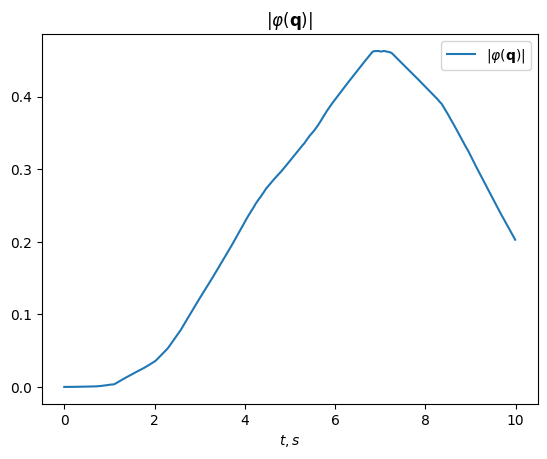

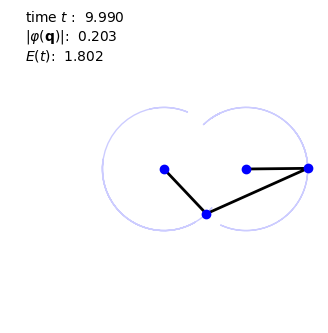

In [7]:
def task_1_no_ext_no_baumgarte():
    sol = solve_ivp(state_1, (0, T_END), X_0, t_eval=T_SPAN)
    plot_res_task_1(sol.y.T, 'task_1_no_ext_no_baumgarte', T_SPAN)


task_1_no_ext_no_baumgarte()

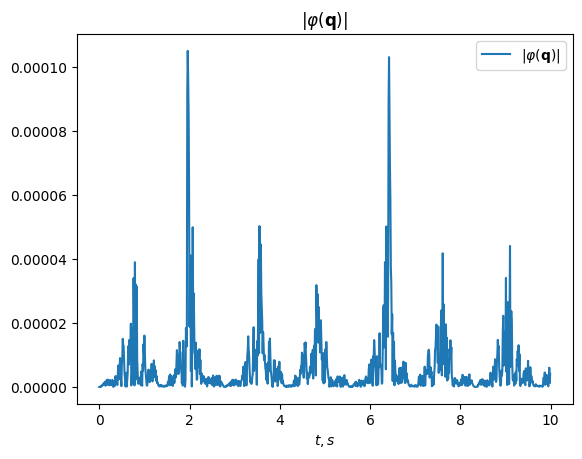

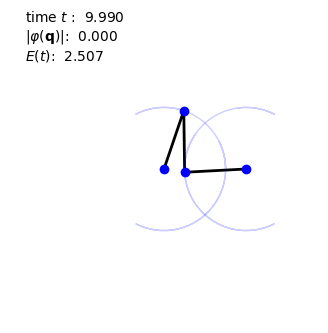

In [8]:
def task_1_no_ext_baumgarte():
    sol = solve_ivp(state_1, (0, T_END), X_0, t_eval=T_SPAN, args=(None, 50))
    plot_res_task_1(sol.y.T, 'task_1_no_ext_baumgarte', T_SPAN)


task_1_no_ext_baumgarte()

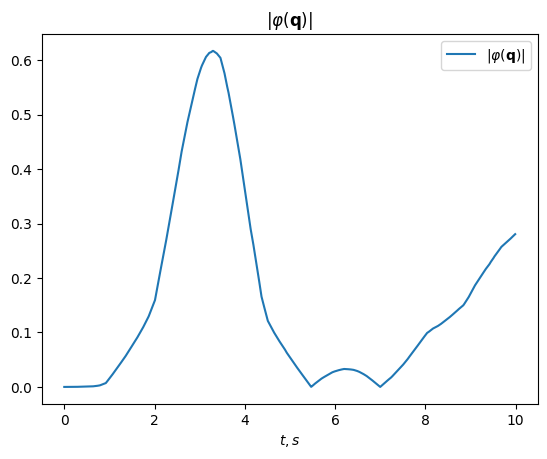

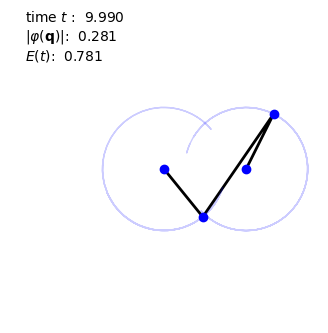

In [9]:
def task_1_ext_no_baumgarte():
    sol = solve_ivp(state_1, (0, T_END), X_0, t_eval=T_SPAN, args=(q_external, 0))
    plot_res_task_1(sol.y.T, 'task_1_ext_no_baumgarte', T_SPAN)


task_1_ext_no_baumgarte()

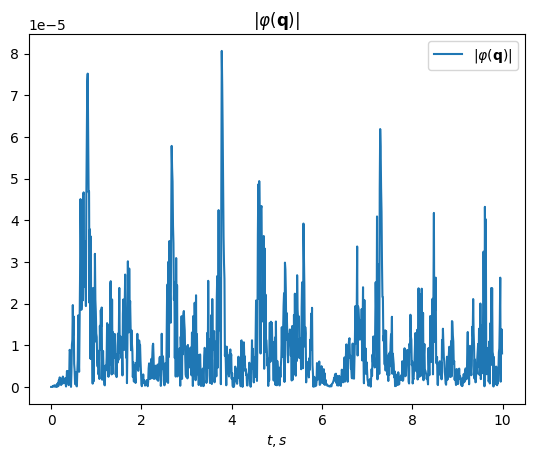

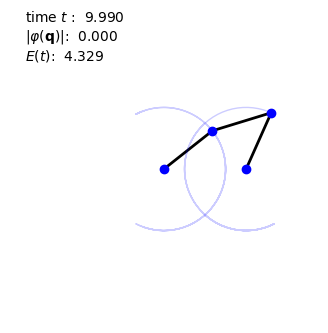

In [10]:
def task_1_ext_baumgarte():
    sol = solve_ivp(state_1, (0, T_END), X_0, t_eval=T_SPAN, args=(q_external, 50))
    plot_res_task_1(sol.y.T, 'task_1_ext_baumgarte', T_SPAN)


task_1_ext_baumgarte()

#### **Problem №2: Bicycle Dynamics**

Consider the following system:

<p align="center">
<img src="images/bicycle.png" alt="drawing" width="70%" style="margin:auto"/>
</p>


with parameters given by:



In [11]:
m1 = 1.0  # [kg] - mass distributed around front wheel
m2 = 2.0  # [kg] - mass distributed around rear wheel
I2 = 0.1  # [kg*m^2] - inertia of front wheel
I1 = 1.0  # [kg*m^2] - combined inertia of frame and rear wheel
l = 0.5  # [m] - length between wheels


Do the following:

* **[10 points]** Propose the coordinates that will represent configuration of the system, derive the unconstrained dynamics, introduce the appropriate constraints (holonomic and nonholonomic) and convert them in to generalized form: $\mathbf{A}(\mathbf{q},\dot{\mathbf{q}},t) \ddot{\mathbf{q}} = \mathbf{b}(\mathbf{q}, \dot{\mathbf{q}}, t)$.

* **[15 points]** Set the external forces $\mathbf{Q}$ to represent the actuation of the system as it shown on the Fig. (b), simulate the behaviour of the system using Runge-Kutta, starting from feasible configuration similar to on the above figure while letting $u_1 = 4$ and $u_2 = 0$, plot the trajectories, and time evoluation of constraints. Animate the resulting motion. Introduce and tune the bamguart stabilization

* **[5 points]** Change the actuation forces to represent the given on figure, with $u_1 = 4$ and $u_2 =  5(1.2\sin(t) - \alpha) - \dot{\alpha}$, repeat the above steps. Discuss the results.
---


## Derivation

I choose $x, y, \theta_1, \theta_2$ as generalized coordinates. $x, y$ - position of $m_1$, $\theta_1$ - angle $m_2, m_1$ and horizont, $\theta_2$ - angle of rear wheel respect to line $m_1, m_2$. Thus, we have the following mass matrix:

$$
M(\mathbf{q}) =
\begin{bmatrix}
m_1 + m_2 & 0 & -m_2 l \sin \theta_1 & 0 \\
0 & m_1 + m_2 & m_2 l \cos \theta_1 & 0 \\
-m_2 l \sin \theta_1 & m_2 l \cos \theta_1 & I_1 + I_2 + m_2 l^2 & 0 \\
0 & 0 & 0 & I_2
\end{bmatrix}
$$

Now we can compute Coriolis and Centrifugal Matrix:

$$
C(\mathbf{q}, \mathbf{\dot{q}}) =
\begin{bmatrix}
0 & 0 & -m_2 l \dot{\theta}_1 \cos \theta_1 & 0 \\
0 & 0 & -m_2 l \dot{\theta}_1 \sin \theta_1 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0
\end{bmatrix}
$$

So,

$$
Q_s =
Q -
\begin{bmatrix}
-m_2 l \dot{\theta}_1^2 \cos \theta_1 \\
-m_2 l \dot{\theta}_1^2 \sin \theta_1 \\
0 \\ 0
\end{bmatrix} = \:(\text{case a})\:
\begin{bmatrix}
u_1 \cos \theta_1 + m_2 l \dot{\theta}_1^2 \cos \theta_1 \\
u_1 \sin \theta_1 + m_2 l \dot{\theta}_1^2 \sin \theta_1 \\
0 \\ u_2
\end{bmatrix} = \:(\text{case b})\:
\begin{bmatrix}
u_1 \cos (\theta_1 + \theta_2) + m_2 l \dot{\theta}_1^2 \cos \theta_1 \\
u_1 \sin (\theta_1 + \theta_2) + m_2 l \dot{\theta}_1^2 \sin \theta_1 \\
u_1 l \sin \theta_2 \\ u_2
\end{bmatrix}
$$

In the following generalized coordinates we would have only two nonholonomic constraints:

$$
\psi_1 =
\begin{bmatrix} \dot{x} & \dot{y} \end{bmatrix}
\begin{bmatrix} -\sin \theta_1 \\ \cos \theta_1 \end{bmatrix}, \:
\psi_2 =
\begin{bmatrix}
\dot{x} - l \dot{\theta}_1 \sin \theta_1 &
\dot{y} + l \dot{\theta}_1 \cos \theta_1
\end{bmatrix}
\begin{bmatrix} -\sin (\theta_1 + \theta_2) \\ \cos (\theta_1 + \theta_2) \end{bmatrix}
$$

Therefore,

$$
A(\mathbf{q}, \mathbf{\dot{q}}, t) =
\begin{bmatrix}
-\sin \theta_1 & \cos \theta_1 & 0 & 0 \\
-\sin (\theta_1 + \theta_2) & \cos (\theta_1 + \theta_2) & l \cos \theta_2 & 0
\end{bmatrix}
$$

$$
b(\mathbf{q}, \mathbf{\dot{q}}, t) =
\begin{bmatrix}
(\dot{y} \sin \theta_1 + \dot{x} \cos \theta_1) \dot{\theta}_1 \\
(\dot{y} \sin (\theta_1 + \theta_2) + \dot{x} \cos (\theta_1 + \theta_2)) (\dot{\theta}_1 + \dot{\theta}_2) +
l \dot{\theta}_1 \dot{\theta}_2 \sin \theta_2
\end{bmatrix}
$$

In [12]:
import sympy as sp

In [13]:
t_sym = sp.Symbol('t')
masses = sp.symbols('m_1,m_2')
_qs = sp.Function('x')(t_sym), sp.Function('y')(t_sym), sp.Function(r'\theta_1')(t_sym), sp.Function(r'\theta_2')(t_sym)
_dot_qs = [_q.diff(t_sym) for _q in _qs]
l_sym = sp.Symbol('l')
ins = sp.symbols('I_1,I_2')

In [14]:
pos_1 = sp.Matrix([_qs[0], _qs[1]])
pos_2 = sp.Matrix([_qs[0] + l_sym * sp.cos(_qs[2]), _qs[1] + l_sym * sp.sin(_qs[2])])

jac_1: sp.Matrix = pos_1.jacobian(_qs)
jac_2: sp.Matrix = pos_2.jacobian(_qs)
jac_1.simplify()
jac_2.simplify()

mass_matrix: sp.Matrix = masses[0] * jac_1.T * jac_1 + masses[1] * jac_2.T * jac_2
mass_matrix.simplify()
mass_matrix[2, 2] += ins[0] + ins[1]
mass_matrix[3, 3] += ins[1]

In [15]:
mass_matrix

Matrix([
[              m_1 + m_2,                      0, -l*m_2*sin(\theta_1(t)),   0],
[                      0,              m_1 + m_2,  l*m_2*cos(\theta_1(t)),   0],
[-l*m_2*sin(\theta_1(t)), l*m_2*cos(\theta_1(t)),    I_1 + I_2 + l**2*m_2,   0],
[                      0,                      0,                       0, I_2]])

In [16]:
def christoffel(mass: sp.Matrix, i: int, j: int, k: int) -> sp.Symbol:
    return sp.simplify((mass[k, j].diff(_qs[i]) + mass[k, i].diff(_qs[j]) - mass[i, j].diff(_qs[k])) / 2)


def coriolis(mass: sp.Matrix) -> sp.Matrix:
    res = sp.zeros(4, 4)
    for k in range(4):
        for j in range(4):
            for i in range(4):
                res[k, j] += christoffel(mass, i, j, k) * _qs[i].diff(t_sym)
    return sp.simplify(res)


corr = coriolis(mass_matrix)

In [17]:
corr_force: sp.Matrix = corr * sp.Matrix(_dot_qs)
corr_force.simplify()
corr_force

Matrix([
[-l*m_2*cos(\theta_1(t))*Derivative(\theta_1(t), t)**2],
[-l*m_2*sin(\theta_1(t))*Derivative(\theta_1(t), t)**2],
[                                                    0],
[                                                    0]])

In [18]:
psi_1 = sp.Matrix([_dot_qs[0], _dot_qs[1]]).T * sp.Matrix([-sp.sin(_qs[2]), sp.cos(_qs[2])])
psi_1 = psi_1[0, 0]
psi_1.simplify()
psi_2 = sp.Matrix(
    [
        _dot_qs[0] - l_sym * _dot_qs[2] * sp.sin(_qs[2]),
        _dot_qs[1] + l_sym * _dot_qs[2] * sp.cos(_qs[2])
    ]
).T * sp.Matrix([-sp.sin(_qs[2] + _qs[3]), sp.cos(_qs[2] + _qs[3])])
psi_2 = psi_2[0, 0]
psi_2.simplify()

psi = sp.Matrix([psi_1, psi_2])
psi.simplify()

In [19]:
psi

Matrix([
[                                                                           -sin(\theta_1(t))*Derivative(x(t), t) + cos(\theta_1(t))*Derivative(y(t), t)],
[l*cos(\theta_2(t))*Derivative(\theta_1(t), t) - sin(\theta_1(t) + \theta_2(t))*Derivative(x(t), t) + cos(\theta_1(t) + \theta_2(t))*Derivative(y(t), t)]])

In [20]:
b_vec: sp.Matrix = -sp.simplify(psi.jacobian(_qs)) * sp.Matrix(_dot_qs)
b_vec.simplify()
b_vec

Matrix([
[                                                                                                                                                                                                                   (sin(\theta_1(t))*Derivative(y(t), t) + cos(\theta_1(t))*Derivative(x(t), t))*Derivative(\theta_1(t), t)],
[(sin(\theta_1(t) + \theta_2(t))*Derivative(y(t), t) + cos(\theta_1(t) + \theta_2(t))*Derivative(x(t), t))*Derivative(\theta_1(t), t) + (l*sin(\theta_2(t))*Derivative(\theta_1(t), t) + sin(\theta_1(t) + \theta_2(t))*Derivative(y(t), t) + cos(\theta_1(t) + \theta_2(t))*Derivative(x(t), t))*Derivative(\theta_2(t), t)]])

In [21]:
a_mat: sp.Matrix = psi.jacobian(_dot_qs)
a_mat.simplify()
a_mat

Matrix([
[              -sin(\theta_1(t)),               cos(\theta_1(t)),                  0, 0],
[-sin(\theta_1(t) + \theta_2(t)), cos(\theta_1(t) + \theta_2(t)), l*cos(\theta_2(t)), 0]])

## Simulation

In [22]:
mass_matrix_lambda = sp.lambdify(masses + ins + (l_sym,) + _qs, mass_matrix)


def get_mass_matrix(q: np.ndarray) -> np.ndarray:
    return mass_matrix_lambda(m1, m2, I1, I2, l, *q)

In [23]:
corr_f_lambda = sp.lambdify(masses + (l_sym,) + _qs + tuple(_dot_qs), corr_force)


def get_corr_f(q: np.ndarray, dot_q: np.ndarray) -> np.ndarray:
    return corr_f_lambda(m1, m2, l, *q, *dot_q)

In [24]:
psi_lambda = sp.lambdify((l_sym,) + _qs + tuple(_dot_qs), psi)


def get_psi(q: np.ndarray, dot_q: np.ndarray) -> np.ndarray:
    return psi_lambda(l, *q, *dot_q)

In [25]:
a_lambda = sp.lambdify((l_sym,) + _qs, a_mat)


def get_a_mat(q: np.ndarray) -> np.ndarray:
    return a_lambda(l, *q)

In [26]:
b_lambda = sp.lambdify((l_sym,) + _qs + tuple(_dot_qs), b_vec)


def get_b_vec(q: np.ndarray, dot_q: np.ndarray) -> np.ndarray:
    return b_lambda(l, *q, *dot_q)

In [27]:
def energy_2(q: np.ndarray, dot_q: np.ndarray) -> float:
    return 0.5 * dot_q.dot(
        get_mass_matrix(q).dot(dot_q)
    )

In [28]:
def mass_sqrt(mat: np.ndarray) -> np.ndarray:
    e_values, e_vectors = np.linalg.eig(mat)
    return e_vectors.T @ np.diag(np.sqrt(e_values)) @ e_vectors


def inv_mass_sqrt(mat: np.ndarray) -> np.ndarray:
    e_values, e_vectors = np.linalg.eig(mat)
    return e_vectors.T @ np.diag(1 / np.sqrt(e_values)) @ e_vectors


def state_2(t: float, x: np.ndarray,
            q_ext: Optional[Callable[[np.ndarray, np.ndarray, float], np.ndarray]] = None,
            beta: float = 0) -> np.ndarray:
    q = x[:4]
    dot_q = x[4:]

    m_val = get_mass_matrix(q)
    i_m_val = np.linalg.inv(m_val)
    i_m_sqrt_v = inv_mass_sqrt(m_val)

    a_val = get_a_mat(q)
    b_val = get_b_vec(q, dot_q) - beta * get_psi(q, dot_q)

    q_s_val = -get_corr_f(q, dot_q)
    if q_ext:
        q_s_val += q_ext(q, dot_q, t).reshape((4, 1))

    constraint_p = i_m_sqrt_v @ \
                   np.linalg.pinv(a_val @ i_m_sqrt_v) @ \
                   (b_val - a_val @ i_m_val @ q_s_val)

    return np.r_[
        dot_q,
        (i_m_val @ q_s_val + constraint_p).T[0]
    ]

In [29]:
def plot_res_task_2(result: np.ndarray, title: str, t_span: np.ndarray):
    qs = result[:, :4]
    dot_qs = result[:, 4:]
    psis = np.array([np.linalg.norm(get_psi(_q, _dot_q)) for _q, _dot_q in zip(qs, dot_qs)])
    energies = np.array([energy_2(_q, _dot_q) for _q, _dot_q in zip(qs, dot_qs)])

    points = \
        qs[:, :2], \
            qs[:, :2] + l * np.c_[np.cos(qs[:, 2]), np.sin(qs[:, 2])], \
            qs[:, :2] + l * np.c_[np.cos(qs[:, 2]), np.sin(qs[:, 2])] + \
            (l / 4) * np.c_[np.cos(qs[:, 2] + qs[:, 3]), np.sin(qs[:, 2] + qs[:, 3])]

    plt.title(r'$|\psi(\mathbf{q})|$')
    plt.plot(t_span, psis, label=r'$|\psi(\mathbf{q})|$')
    plt.xlabel('$t,s$')
    plt.legend(loc='best')
    plt.show()

    stats = [
        [r'time $t$ ', t_span],
        [r'$|\psi(\mathbf{q})|$', psis],
        [r'$E(t)$', energies]
    ]
    visualize_n_pendulum(
        points, title,
        stats=stats,
        axes=False,
        show=True,
        trace_len=0.2,
        dt=DT * 1000
    )

In [30]:
T_END = 5
DT = 0.01
T_SPAN = np.arange(0, T_END, DT)
X_0 = np.array(
    [
        0, 0, 0, 3 * np.pi / 4,
        0, 0, 0, 0
    ]
)

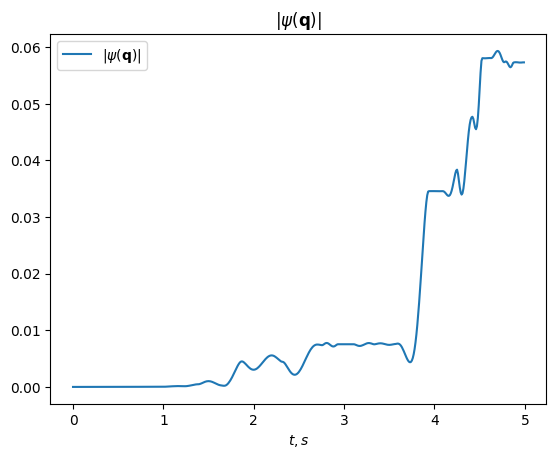

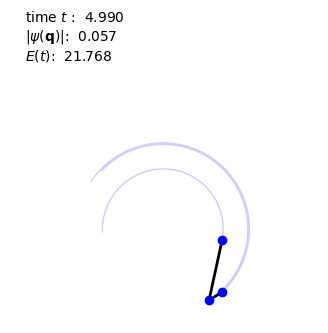

In [31]:
def q_ext_case_a_1(q: np.ndarray, dot_q: np.ndarray, t: float) -> np.ndarray:
    return np.array(
        [4 * np.cos(q[2]), 4 * np.sin(q[2]), 0, 0]
    )


def task_2_ext_1a_no_baumgarte():
    sol = solve_ivp(state_2, (0, T_END), X_0, t_eval=T_SPAN, args=(q_ext_case_a_1, 0))
    plot_res_task_2(sol.y.T, 'task_2_ext_1a_no_baumgarte', T_SPAN)


task_2_ext_1a_no_baumgarte()

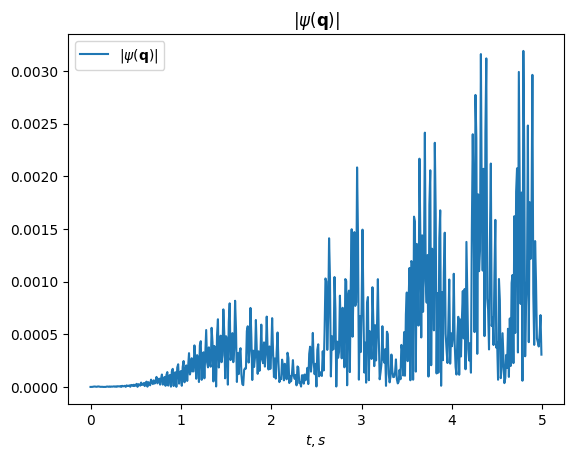

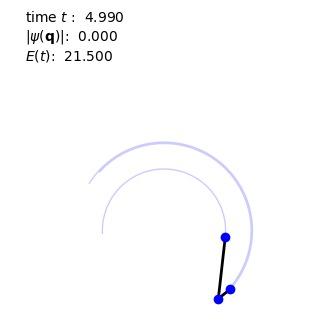

In [32]:
def task_2_ext_1a_baumgarte():
    sol = solve_ivp(state_2, (0, T_END), X_0, t_eval=T_SPAN, args=(q_ext_case_a_1, 50))
    plot_res_task_2(sol.y.T, 'task_2_ext_1a_baumgarte', T_SPAN)


task_2_ext_1a_baumgarte()

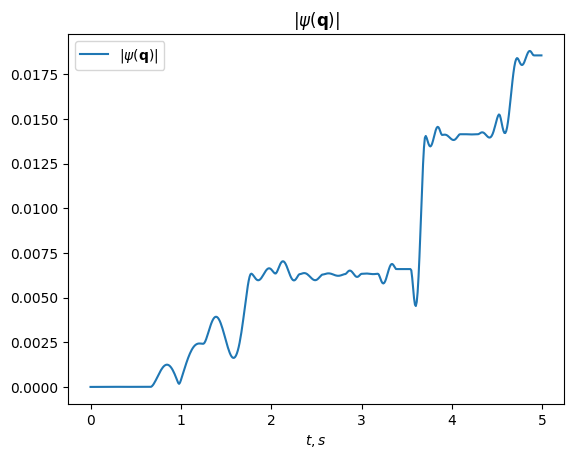

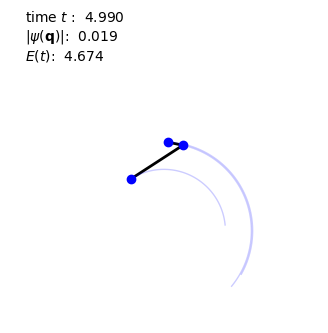

In [33]:
def q_ext_case_b_1(q: np.ndarray, dot_q: np.ndarray, t: float) -> np.ndarray:
    return np.array(
        [4 * np.cos(q[2] + q[3]), 4 * np.sin(q[2] + q[3]), 4 * l * np.sin(q[3]), 0]
    )


def task_2_ext_1b_no_baumgarte():
    sol = solve_ivp(state_2, (0, T_END), X_0, t_eval=T_SPAN, args=(q_ext_case_b_1, 0))
    plot_res_task_2(sol.y.T, 'task_2_ext_1b_no_baumgarte', T_SPAN)


task_2_ext_1b_no_baumgarte()

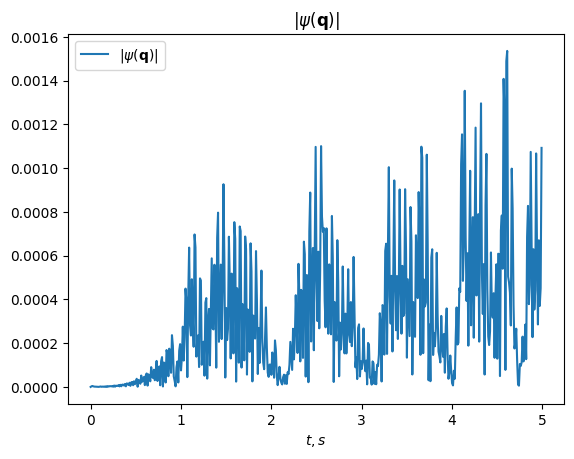

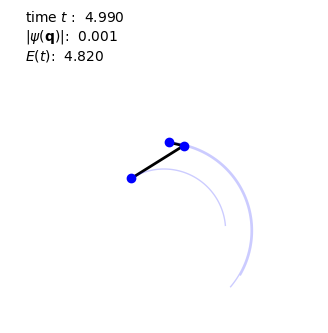

In [34]:
def task_2_ext_1b_baumgarte():
    sol = solve_ivp(state_2, (0, T_END), X_0, t_eval=T_SPAN, args=(q_ext_case_b_1, 50))
    plot_res_task_2(sol.y.T, 'task_2_ext_1b_baumgarte', T_SPAN)


task_2_ext_1b_baumgarte()

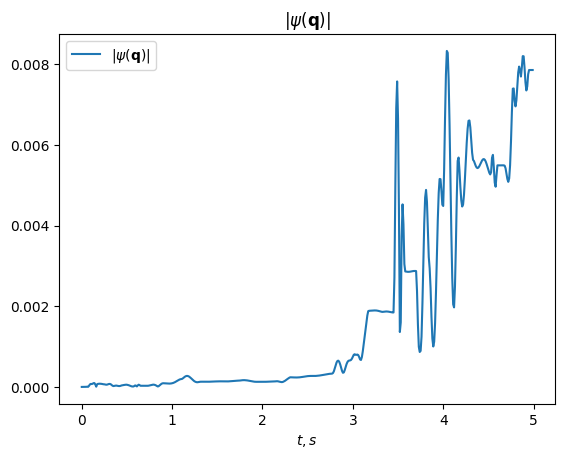

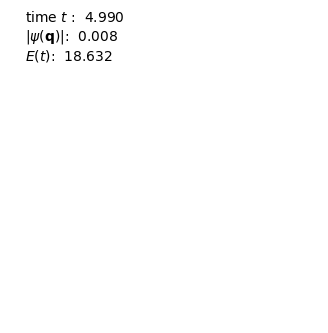

In [35]:
def q_ext_case_a_2(q: np.ndarray, dot_q: np.ndarray, t: float) -> np.ndarray:
    u_1 = 4
    u_2 = 5 * (1.2 * np.sin(t) - q[3]) - dot_q[3]
    return np.array(
        [u_1 * np.cos(q[2]), u_1 * np.sin(q[2]), 0, u_2]
    )


def task_2_ext_2a_no_baumgarte():
    sol = solve_ivp(state_2, (0, T_END), X_0, t_eval=T_SPAN, args=(q_ext_case_a_2, 0))
    plot_res_task_2(sol.y.T, 'task_2_ext_2a_no_baumgarte', T_SPAN)


task_2_ext_2a_no_baumgarte()

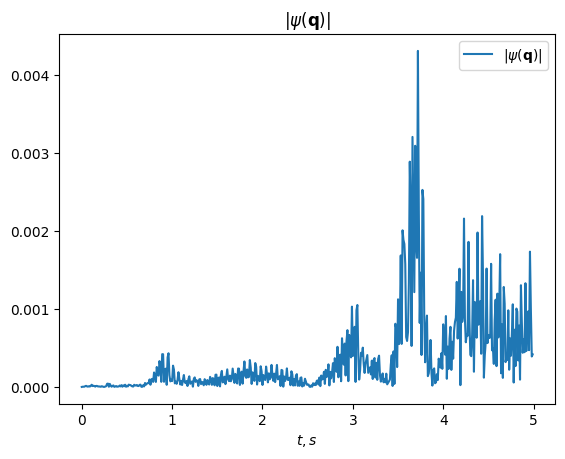

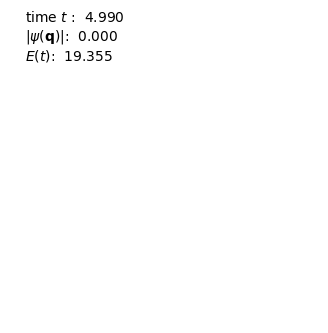

In [36]:
def task_2_ext_2a_baumgarte():
    sol = solve_ivp(state_2, (0, T_END), X_0, t_eval=T_SPAN, args=(q_ext_case_a_2, 50))
    plot_res_task_2(sol.y.T, 'task_2_ext_2a_baumgarte', T_SPAN)


task_2_ext_2a_baumgarte()

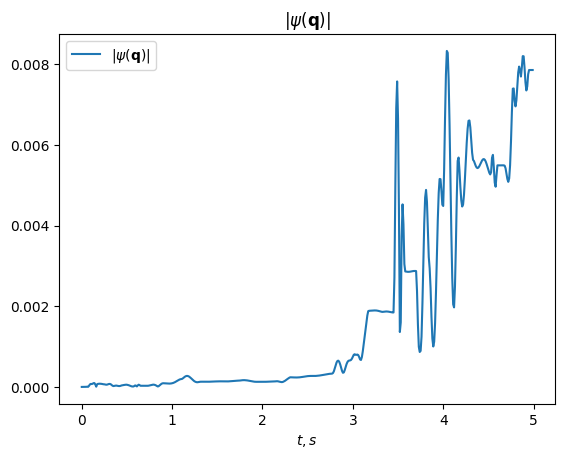

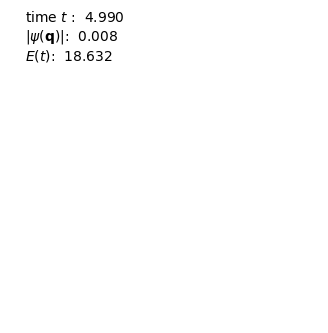

In [37]:
def q_ext_case_b_2(q: np.ndarray, dot_q: np.ndarray, t: float) -> np.ndarray:
    u_1 = 4
    u_2 = 5 * (1.2 * np.sin(t) - q[3]) - dot_q[3]
    return np.array(
        [u_1 * np.cos(q[2] + q[3]), u_1 * np.sin(q[2] + q[3]), u_1 * l * np.sin(q[3]), u_2]
    )


def task_2_ext_2b_no_baumgarte():
    sol = solve_ivp(state_2, (0, T_END), X_0, t_eval=T_SPAN, args=(q_ext_case_a_2, 0))
    plot_res_task_2(sol.y.T, 'task_2_ext_2b_no_baumgarte', T_SPAN)


task_2_ext_2b_no_baumgarte()

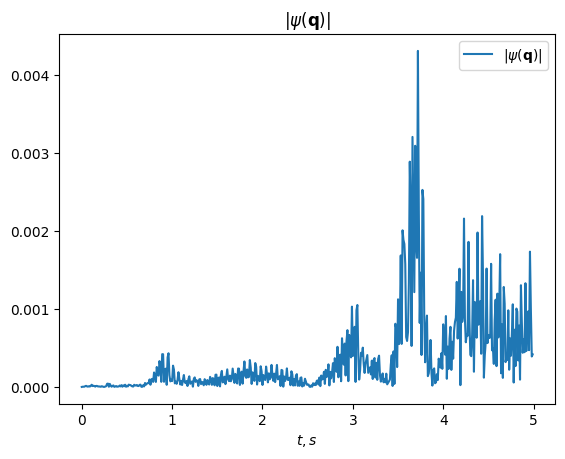

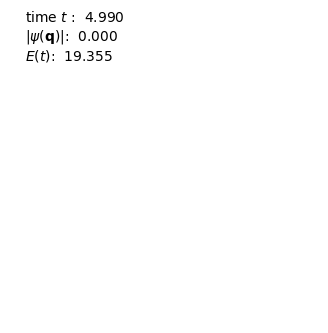

In [38]:
def task_2_ext_2b_baumgarte():
    sol = solve_ivp(state_2, (0, T_END), X_0, t_eval=T_SPAN, args=(q_ext_case_a_2, 50))
    plot_res_task_2(sol.y.T, 'task_2_ext_2b_baumgarte', T_SPAN)


task_2_ext_2b_baumgarte()

#### **Problem №3: Variational Integrators and Quaternions**

Consider the rotation of single rigid body with associated kinetic energy given by:

$$
    \mathcal{K} = \frac{1}{2} \boldsymbol{\omega}^T \mathbf{I} \boldsymbol{\omega}
$$

with inertia matrix given derived with respect to principle axes as $\mathbf{I} = \text{diag}[I_x, I_y, I_z]$ and inertia parameters are given by:


In [139]:
Ix = 0.1  # [kg*m^2] inertia around x axis
Iy = 0.2  # [kg*m^2] inertia around y axis
Iz = 0.4  # [kg*m^2] inertia around z axis
II = np.diag([Ix, Iy, Iz])
II_inv = np.linalg.inv(II)

Do the following:

* **[10 points]** Choose **unit quaternions** $\mathbf{q} \in \mathbb{S}^3$  to represent configuration of the system and define the **discrete Lagrangian** in this coordinates. 
  * Note: you may define the angular speed through quaternion derivative as follows: $\hat{\boldsymbol{\omega}} = 2\mathbf{q}^{*} \otimes \dot{\mathbf{q}}$,
where $\hat{\boldsymbol{\omega}} = [0, \boldsymbol{\omega}]$ and $\mathbf{q}^{*}$ is quaternion conjugate. 
* **[15 points]** Derive the **constrained discrete Euler-Lagrange** equations in momentum form. Simulate the system with sampling rate $dt = 0.01$ [s] starting from initial quaternion $\mathbf{q}(0) = [1,0,0,0]$ and initial velocities $\omega_1(0)= [6, 0.1, 0.1]$. Repeat the same for $\omega_2(0) = [0.1, 6, 0.1]$, $\omega_2(0) = [0.1, 0.1, 6]$, animate the trajectories (rotating frame) and discuss result. 
* **[10 points]** Plot the energy $\mathcal{K}(t)$, norm of momentum $\|\mathbf{p}(t)\|$ and norm of quaternion $\|\mathbf{q}(t)\|$. Compare the result with Euler integration (with and without quaternion normalization)
---

## Derivation

Lagrangian:

$$
\mathcal{L} = K - P = \frac{1}{2} \boldsymbol{\omega}^T \mathbf{I} \boldsymbol{\omega} =
\frac{1}{2} \boldsymbol{\hat{\omega}}^T \begin{bmatrix} 0 & 0 \\ 0 & \mathbf{I} \end{bmatrix} \boldsymbol{\hat{\omega}} =
\frac{1}{2} (2\mathbf{q}^{*} \otimes \dot{\mathbf{q}})^T \begin{bmatrix} 0 & 0 \\ 0 & \mathbf{I} \end{bmatrix} (2\mathbf{q}^{*} \otimes \dot{\mathbf{q}}) =
2 (\mathbf{q}^{*} \otimes \dot{\mathbf{q}})^T \begin{bmatrix} 0 & 0 \\ 0 & \mathbf{I} \end{bmatrix} (\mathbf{q}^{*} \otimes \dot{\mathbf{q}}) =
2 (L(\mathbf{q}^{*}) \dot{\mathbf{q}})^T \begin{bmatrix} 0 & 0 \\ 0 & \mathbf{I} \end{bmatrix} (L(\mathbf{q}^{*}) \dot{\mathbf{q}})
$$

So,

$$
\mathcal{L} = 2 [\dot{\mathbf{q}}^T \hat{L}^T(\mathbf{q}) \mathbf{\hat{I}} \hat{L}(\mathbf{q}) \dot{\mathbf{q}}] = \frac{1}{2} \dot{\mathbf{q}}^T \mathbf{U} \dot{\mathbf{q}},
\: \text{where}
$$

$$
U = 4 \hat{L}^T(\mathbf{q}) \mathbf{\hat{I}} \hat{L}(\mathbf{q}), \: \mathbf{\hat{I}} = \begin{bmatrix} 0 & 0 \\ 0 & \mathbf{I} \end{bmatrix} \: \text{and} \:
\hat{L}(\mathbf{q}) =
\begin{bmatrix}
q_0 & q_1 & q_2 & q_3 \\
-q_1 & q_0 & q_3 & -q_2 \\
-q_2 & -q_3 & q_0 & q_1 \\
-q_3 & q_2 & -q_1 & q_0
\end{bmatrix}
$$

Discrete Lagrangian:

$$
\mathcal{L}_D(\mathbf{q}_0, \mathbf{q}_1) = \mathcal{L}(\frac{\mathbf{q}_0 + \mathbf{q}_1}{2}, \frac{\mathbf{q}_1 - \mathbf{q}_0}{\Delta t}) \Delta t
$$

$$
D_1 \mathcal{L}_D = \frac{\Delta t}{2} \frac{\partial \mathcal{L}} {\partial \mathbf{q}}^T - \frac{\partial \mathcal{L}} {\partial \mathbf{\dot{q}}}^T \:
D_2 \mathcal{L}_D = \frac{\Delta t}{2} \frac{\partial \mathcal{L}} {\partial \mathbf{q}}^T + \frac{\partial \mathcal{L}} {\partial \mathbf{\dot{q}}}^T
$$

Momentum:

$$
\mathbf{p}_0 = U \mathbf{\dot{q}}_0, \: \mathbf{p}_k = -D_1 \mathcal{L}_D(q_k,q_{k+1}), \: \mathbf{p}_{k+1} = D_2 \mathcal{L}_D(q_k,q_{k+1})
$$

Momentum for $\boldsymbol{\omega}$:

$$\mathbf{\hat{p}}_{\boldsymbol{\omega}} = \frac{1}{2} (\hat{L}^T)^{-1} p$$

Constraint:

$$
\varphi(\mathbf{q}_k) = \frac{|\mathbf{q}_k|^2 - 1}{2} \Rightarrow \nabla \varphi(\mathbf{q}_k) = \mathbf{q}_k
$$

Hence, we have a following **constrained discrete Euler-Lagrange**:

$$
\begin{cases}
\mathbf{p}_k + D_1\mathcal{L}_D(\mathbf{q}_k, \mathbf{q}_{k+1}) = \lambda_k \mathbf{q}_k & \: (\text{simplifying}\nabla \varphi(\mathbf{q}_k)) \\
\varphi(\mathbf{q}_{k + 1}) = 0
\end{cases}
\xrightarrow{\text{Compute}}
\mathbf{p}_{k + 1} = D_2\mathcal{L}_D(\mathbf{q}_k, \mathbf{q}_{k+1})
$$

In [179]:
DT = 0.01
T_END = 10
T_SPAN = np.arange(0, T_END, DT)
Q_0 = np.array([1, 0, 0, 0])

In [180]:
delta_t = sp.Symbol('\Delta t')
i_principal = sp.symbols('I_x,I_y,I_z')
inertia_sym: sp.Matrix = sp.zeros(4, 4)
inertia_sym[1, 1] = i_principal[0]
inertia_sym[2, 2] = i_principal[1]
inertia_sym[3, 3] = i_principal[2]
_qs = sp.symbols('q_0,q_1,q_2,q_3')
_dot_qs = sp.symbols('\dot{q}_0,\dot{q}_1,\dot{q}_2,\dot{q}_3')
_l_hat = sp.Matrix(
    [
        [_qs[0], _qs[1], _qs[2], _qs[3]],
        [-_qs[1], _qs[0], _qs[3], -_qs[2]],
        [-_qs[2], -_qs[3], _qs[0], _qs[1]],
        [-_qs[3], _qs[2], -_qs[1], _qs[0]],
    ]
)
u_sym: sp.Matrix = 4 * _l_hat.T * inertia_sym * _l_hat
u_sym.simplify()

In [181]:
u_sym

Matrix([
[    4*I_x*q_1**2 + 4*I_y*q_2**2 + 4*I_z*q_3**2, -4*I_x*q_0*q_1 + 4*I_y*q_2*q_3 - 4*I_z*q_2*q_3, -4*I_x*q_1*q_3 - 4*I_y*q_0*q_2 + 4*I_z*q_1*q_3,  4*I_x*q_1*q_2 - 4*I_y*q_1*q_2 - 4*I_z*q_0*q_3],
[-4*I_x*q_0*q_1 + 4*I_y*q_2*q_3 - 4*I_z*q_2*q_3,     4*I_x*q_0**2 + 4*I_y*q_3**2 + 4*I_z*q_2**2,  4*I_x*q_0*q_3 - 4*I_y*q_0*q_3 - 4*I_z*q_1*q_2, -4*I_x*q_0*q_2 - 4*I_y*q_1*q_3 + 4*I_z*q_0*q_2],
[-4*I_x*q_1*q_3 - 4*I_y*q_0*q_2 + 4*I_z*q_1*q_3,  4*I_x*q_0*q_3 - 4*I_y*q_0*q_3 - 4*I_z*q_1*q_2,     4*I_x*q_3**2 + 4*I_y*q_0**2 + 4*I_z*q_1**2, -4*I_x*q_2*q_3 + 4*I_y*q_0*q_1 - 4*I_z*q_0*q_1],
[ 4*I_x*q_1*q_2 - 4*I_y*q_1*q_2 - 4*I_z*q_0*q_3, -4*I_x*q_0*q_2 - 4*I_y*q_1*q_3 + 4*I_z*q_0*q_2, -4*I_x*q_2*q_3 + 4*I_y*q_0*q_1 - 4*I_z*q_0*q_1,     4*I_x*q_2**2 + 4*I_y*q_1**2 + 4*I_z*q_0**2]])

In [182]:
lagrangian_sym: sp.Matrix = 0.5 * sp.Matrix(list(_dot_qs)).T * u_sym * sp.Matrix(list(_dot_qs))
lagrangian_sym.simplify()

In [183]:
d_1_ld: sp.Matrix = delta_t * lagrangian_sym.jacobian(_qs).T / 2 - lagrangian_sym.jacobian(_dot_qs).T
d_2_ld: sp.Matrix = delta_t * lagrangian_sym.jacobian(_qs).T / 2 + lagrangian_sym.jacobian(_dot_qs).T
d_1_ld.simplify()
d_2_ld.simplify()

In [184]:
d_1_ld

Matrix([
[-1.0*\Delta t*(\dot{q}_0*(I_x*\dot{q}_1*q_1 + I_y*\dot{q}_2*q_2 + I_z*\dot{q}_3*q_3) + \dot{q}_1*(I_x*\dot{q}_0*q_1 - 2*I_x*\dot{q}_1*q_0 - \dot{q}_2*q_3*(I_x - I_y) + \dot{q}_3*q_2*(I_x - I_z)) - \dot{q}_2*(-I_y*\dot{q}_0*q_2 + 2*I_y*\dot{q}_2*q_0 + \dot{q}_1*q_3*(I_x - I_y) + \dot{q}_3*q_1*(I_y - I_z)) + \dot{q}_3*(I_z*\dot{q}_0*q_3 - 2*I_z*\dot{q}_3*q_0 + \dot{q}_1*q_2*(I_x - I_z) - \dot{q}_2*q_1*(I_y - I_z))) - 4.0*\dot{q}_0*(I_x*q_1**2 + I_y*q_2**2 + I_z*q_3**2) + 4.0*\dot{q}_1*(I_x*q_0*q_1 - I_y*q_2*q_3 + I_z*q_2*q_3) + 4.0*\dot{q}_2*(I_x*q_1*q_3 + I_y*q_0*q_2 - I_z*q_1*q_3) + 4.0*\dot{q}_3*(-I_x*q_1*q_2 + I_y*q_1*q_2 + I_z*q_0*q_3)],
[ 1.0*\Delta t*(\dot{q}_0*(2*I_x*\dot{q}_0*q_1 - I_x*\dot{q}_1*q_0 - \dot{q}_2*q_3*(I_x - I_z) + \dot{q}_3*q_2*(I_x - I_y)) - \dot{q}_1*(I_x*\dot{q}_0*q_0 + I_y*\dot{q}_3*q_3 + I_z*\dot{q}_2*q_2) - \dot{q}_2*(I_z*\dot{q}_1*q_2 - 2*I_z*\dot{q}_2*q_1 + \dot{q}_0*q_3*(I_x - I_z) - \dot{q}_3*q_0*(I_y - I_z)) + \dot{q}_3*(-I_y*\dot{q}_1*q_3 + 2

In [185]:
phi = ((sp.Matrix(list(_qs)).T * sp.Matrix(list(_qs)))[0, 0] - 1) / 2
phi = phi.simplify()

In [186]:
grad_phi = sp.Matrix([phi]).jacobian(_qs).T
grad_phi.simplify()
grad_phi

Matrix([
[q_0],
[q_1],
[q_2],
[q_3]])

In [213]:
l_hat_lambda = sp.lambdify(_qs, _l_hat)


def get_l_hat(q: np.ndarray) -> np.ndarray:
    return l_hat_lambda(*q)

In [187]:
u_sym_lambda = sp.lambdify(i_principal + _qs, u_sym)

def get_u(q: np.ndarray) -> np.ndarray:
    return u_sym_lambda(Ix, Iy, Iz, *q)

In [188]:
d_1_ld_lambda = sp.lambdify((delta_t,) + i_principal + _qs + tuple(_dot_qs), d_1_ld)


def get_d_1_ld(q_0: np.ndarray, q_1: np.ndarray, dt: float) -> np.ndarray:
    q = (q_0 + q_1) / 2
    dot_q = (q_1 - q_0) / dt
    return d_1_ld_lambda(dt, Ix, Iy, Iz, *q, *dot_q).T[0]

In [189]:
d_2_ld_lambda = sp.lambdify((delta_t,) + i_principal + _qs + tuple(_dot_qs), d_2_ld)


def get_d_2_ld(q_0: np.ndarray, q_1: np.ndarray, dt: float) -> np.ndarray:
    q = (q_0 + q_1) / 2
    dot_q = (q_1 - q_0) / dt
    return d_2_ld_lambda(dt, Ix, Iy, Iz, *q, *dot_q).T[0]

In [215]:
def q_mul(q1: np.ndarray, q2: np.ndarray) -> np.ndarray:
    return np.array(
        [
            q1[0] * q2[0] - q1[1:].dot(q2[1:]),
            *(q1[0] * q2[1:] + q2[0] * q1[1:] + np.cross(q1[1:], q2[1:]))
        ]
    )


def conj(q: np.ndarray) -> np.ndarray:
    return np.array([q[0], *(-q[1:])])


def complete(v: np.ndarray) -> np.ndarray:
    return np.array([0, *v])


def qt_rot(q: np.ndarray) -> np.ndarray:
    ident = np.eye(3)
    q_c = conj(q)
    return np.c_[
        q_mul(q_mul(q, complete(ident[:, 0])), q_c)[1:],
        q_mul(q_mul(q, complete(ident[:, 1])), q_c)[1:],
        q_mul(q_mul(q, complete(ident[:, 2])), q_c)[1:]
    ]


def get_omega(q: np.ndarray, dot_q: np.ndarray) -> np.ndarray:
    return 2 * q_mul(conj(q), dot_q)


def get_q_dot(q: np.ndarray, omega: np.ndarray) -> np.ndarray:
    return 0.5 * q_mul(q, complete(omega))


def get_phi(q: np.ndarray) -> float:
    return (q.dot(q) - 1) / 2


def to_omega_momentum(p: np.ndarray, q: np.ndarray) -> np.ndarray:
    return 0.5 * np.linalg.inv(get_l_hat(q).T).dot(p)


def system(x: np.ndarray, q_prev: np.ndarray, p_prev: np.ndarray, dt: float) -> np.ndarray:
    return np.r_[p_prev + get_d_1_ld(q_prev, x[:-1], dt) - x[-1] * q_prev, [get_phi(x[:-1])]]
    # return np.r_[complete(p_prev) + get_d_1_ld(q_prev, x[:-1], dt) - x[-1] * q_prev, [get_phi(x[:-1])]]


def update(q: np.ndarray, p: np.ndarray, lbd: float, dt: float) -> Tuple[np.ndarray, np.ndarray, float]:
    root = fsolve(system, np.r_[q, [lbd]], args=(q, p, dt))
    q_next = root[:-1]
    lbd_next = root[-1]
    # omega = get_omega((q + q_next) / 2, (q_next - q) / 2)
    # print(omega)

    p_next = get_d_2_ld(q, root[:-1], dt)

    return q_next, p_next, lbd_next


def simulate(q_0: np.ndarray, p_0: np.ndarray, t_span: np.ndarray, dt: float) -> Tuple[np.ndarray, np.ndarray]:
    qs = [q_0]
    ps = [p_0]
    lbd = 0
    for _ in t_span[1:]:
        q_next, p_next, lbd = update(qs[-1], ps[-1], lbd, dt)
        qs.append(q_next)
        ps.append(p_next)
    return np.array(qs), np.array(ps)

In [191]:
def visualize_rotation(rotation_matrices, title: str, stats=None,):
    axes_t = np.array([rotation_matrices[:, :, 0],
                       rotation_matrices[:, :, 1],
                       rotation_matrices[:, :, 2]])

    n = len(axes_t[0])
    frames = n
    interval = 1 / n

    # ////////////////////
    # Animate the solution
    # ////////////////////

    # Set up figure & 3D axis for animation
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.axis('off')

    # choose a different color for each trajectory
    colors = ['r', 'g', 'b']

    # set up lines and points
    lines = sum([ax.plot([], [], [], '--', c=c, alpha=0.3)
                 for c in colors], [])
    axes = sum([ax.plot([], [], [], '-', c=c, lw=3)
                for c in colors], [])
    pts = sum([ax.plot([], [], [], 'o', c=c, lw=5)
               for c in colors], [])

    corner_text = ax.text(0.02, 0.90, 1.1, '')

    ax.set_xlim((-1.1, 1.1))
    ax.set_ylim((-1.1, 1.1))
    ax.set_zlim((-1.1, 1.1))

    ax.view_init(14, 0)

    def init():
        for line, pt, axs, xi in zip(lines, pts, axes, axes_t):
            x, y, z = xi[:0].T
            line.set_data(x[-lag:], y[-lag:])
            line.set_3d_properties(z[-lag:])
            axs.set_data(np.hstack((0, x[-1:])), np.hstack((0, y[-1:])))
            axs.set_3d_properties(np.hstack((0, z[-1:])))

        return lines + pts + axes

    lag = 35

    def animate(i):
        rate = 1
        j = (rate * i) % n

        stat_text = ''

        for line, pt, axs, xi in zip(lines, pts, axes, axes_t):
            x, y, z = xi[:j].T
            line.set_data(x[-lag:], y[-lag:])
            line.set_3d_properties(z[-lag:])
            axs.set_data(np.hstack((0, x[-1:])), np.hstack((0, y[-1:])))
            axs.set_3d_properties(np.hstack((0, z[-1:])))

            pt.set_data(x[-1:], y[-1:])
            pt.set_3d_properties(z[-1:])

        if stats is not None:
            for stat in stats:
                stat_text += rf'{stat[0]}:  {stat[1][j]:.3f}'
                stat_text += '\n'
            corner_text.set_text(stat_text)

        # ax.view_init(30, 0.3)
        fig.canvas.draw()
        return lines + pts + axes

    # instantiate the animator.
    anim = animation.FuncAnimation(fig, animate,
                                   init_func=init,
                                   frames=frames,
                                   interval=interval,
                                   blit=True)

    with open(f'{title}.html', 'w') as f:
        f.write(anim.to_jshtml())

    return anim

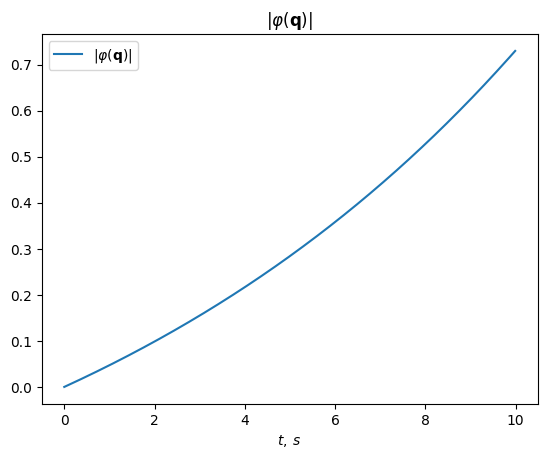

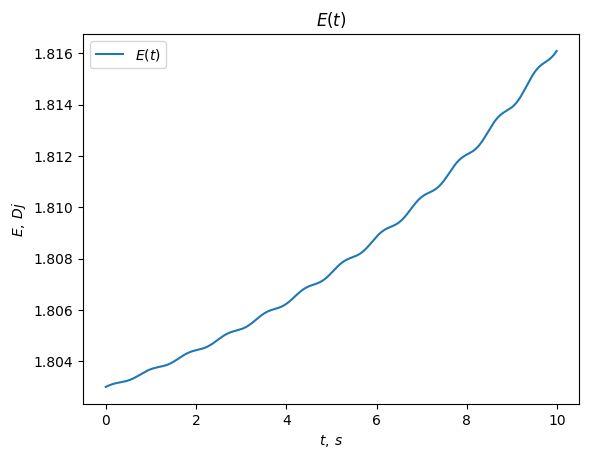

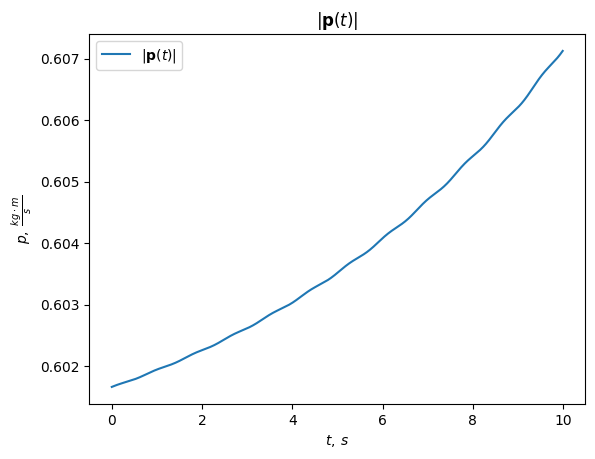

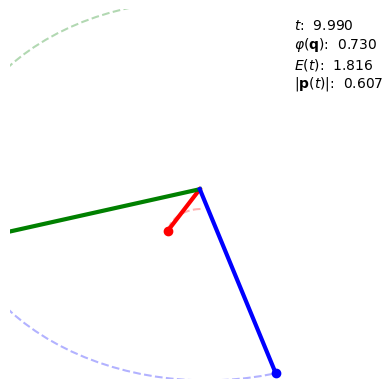

In [198]:
class Solver:
    def __init__(self, x_0: np.ndarray, t_span: np.ndarray,
                 f: Callable[[np.ndarray, float], np.ndarray]):
        self.x_0 = np.array(x_0)
        self.t_span = t_span
        self.f = f
        self.dt = t_span[1] - t_span[0]

    def solve(self) -> np.ndarray:
        raise NotImplementedError()


def state_3(x: np.ndarray, _: float) -> np.ndarray:
    return np.r_[
        get_q_dot(x[:4], x[4:]),
        II_inv.dot(-np.cross(x[4:], II.dot(x[4:])))
    ]


class ForwardEuler(Solver):
    def solve(self) -> np.ndarray:
        res = [self.x_0]
        for t_val in self.t_span[:-1]:
            res.append(
                res[-1] + self.f(res[-1], t_val) * self.dt
            )
        return np.array(res)


def plot_task_3_euler(q_0: np.ndarray, omega_0: np.ndarray, t_span: np.ndarray, title: str, rate: int = 10):
    euler = ForwardEuler(np.r_[q_0, omega_0], t_span, state_3)
    sol = euler.solve()
    qs = sol[:, :4]
    omegas = sol[:, 4:]
    phis = [get_phi(_q) for _q in qs]
    energies = [_omega.dot(II.dot(_omega)) / 2 for _omega in omegas]
    ps = [np.linalg.norm(II.dot(_omega)) for _omega in omegas]

    plt.title(r'$|\varphi(\mathbf{q})|$')
    plt.plot(t_span, phis, label=r'$|\varphi(\mathbf{q})|$')
    plt.xlabel(r'$t, \: s$')
    plt.legend(loc='best')
    plt.show()

    plt.title(r'$E(t)$')
    plt.plot(t_span, energies, label=r'$E(t)$')
    plt.xlabel(r'$t, \: s$')
    plt.ylabel(r'$E, \: Dj$')
    plt.legend(loc='best')
    plt.show()

    plt.title(r'$|\mathbf{p}(t)|$')
    plt.plot(t_span, ps, label=r'$|\mathbf{p}(t)|$')
    plt.xlabel(r'$t, \: s$')
    plt.ylabel(r'$p, \: \frac{kg \cdot m}{s}$')
    plt.legend(loc='best')
    plt.show()

    timestamps = []
    rot_ms = []

    for k in range(len(t_span) // rate):
        k = k * rate
        timestamps.append(t_span[k])
        rot_ms.append(qt_rot(qs[k]))

    stats = [
        ['$t$', timestamps],
        [r'$\varphi(\mathbf{q})$', phis],
        [r'$E(t)$', energies],
        ['$|\mathbf{p}(t)|$', ps],
    ]

    rot_ms = np.array(rot_ms)
    visualize_rotation(rot_ms, title, stats=stats)

plot_task_3_euler(np.array([1, 0, 0, 0]), np.array([6, 0.1, 0.1]), T_SPAN, 'task_3_euler_1', rate=1)

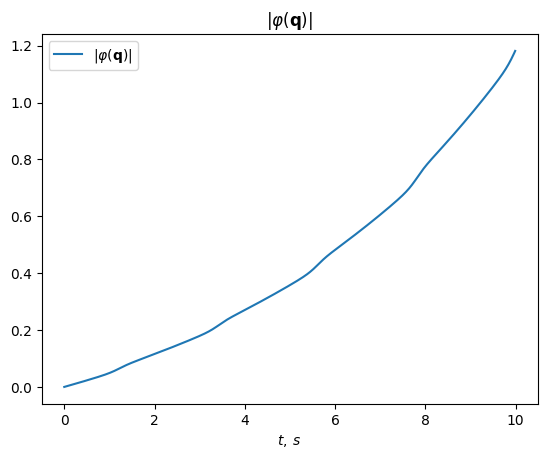

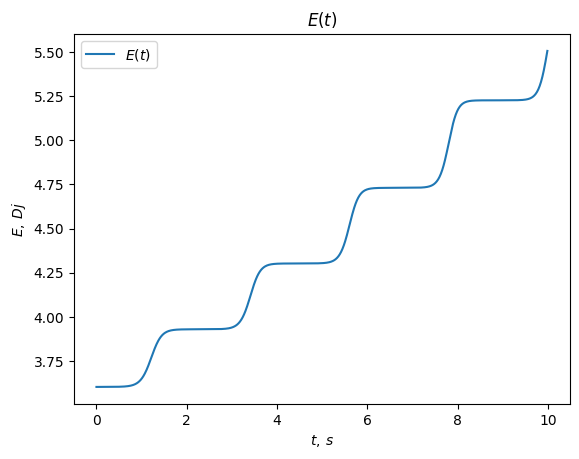

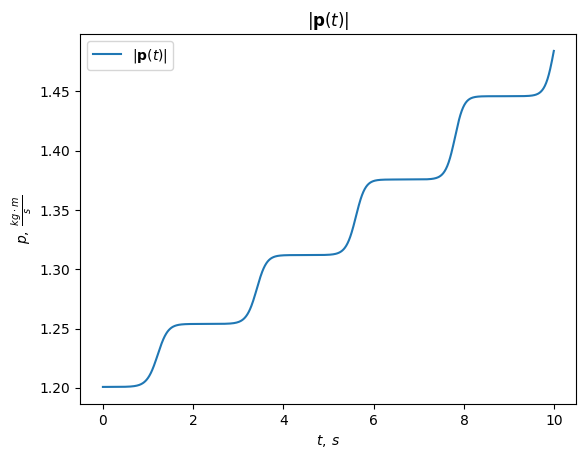

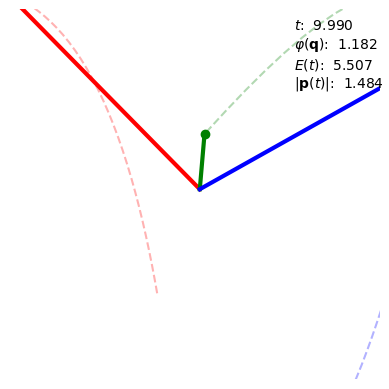

In [199]:
plot_task_3_euler(np.array([1, 0, 0, 0]), np.array([0.1, 6, 0.1]), T_SPAN, 'task_3_euler_2', rate=1)

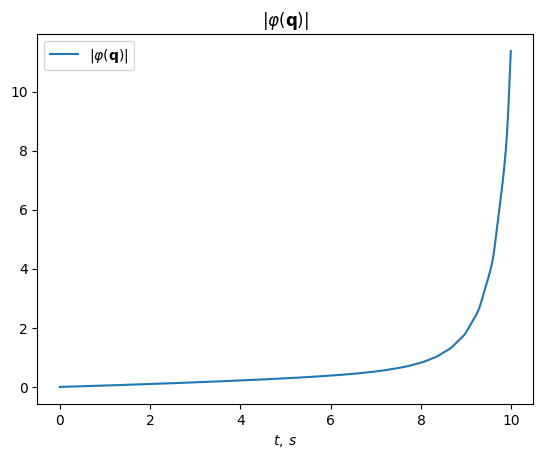

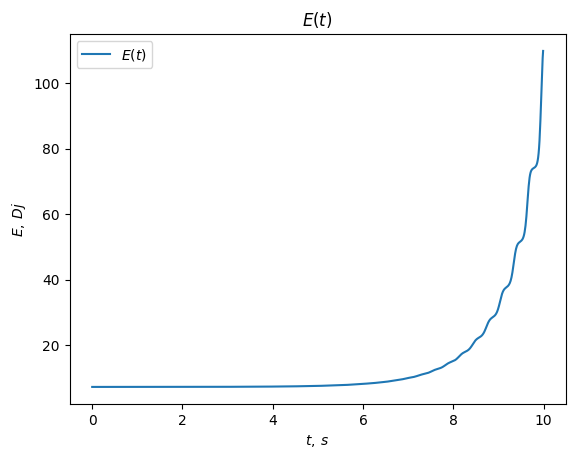

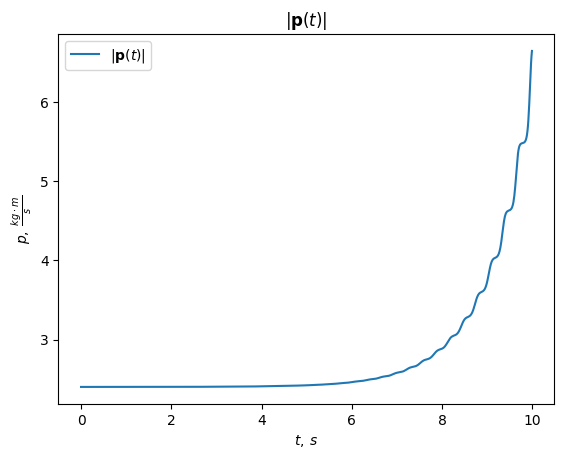

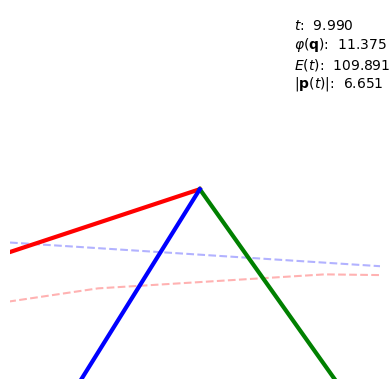

In [200]:
plot_task_3_euler(np.array([1, 0, 0, 0]), np.array([0.1, 0.1, 6]), T_SPAN, 'task_3_euler_3', rate=1)

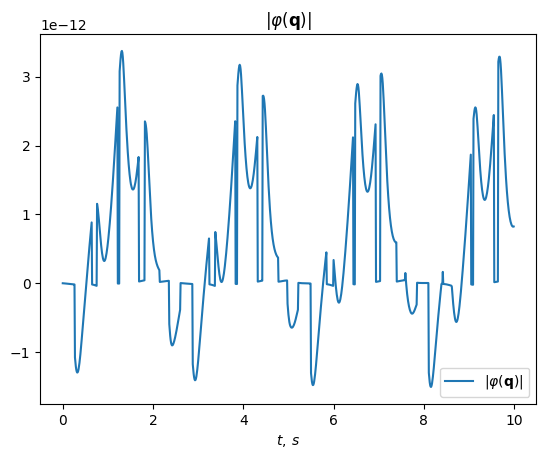

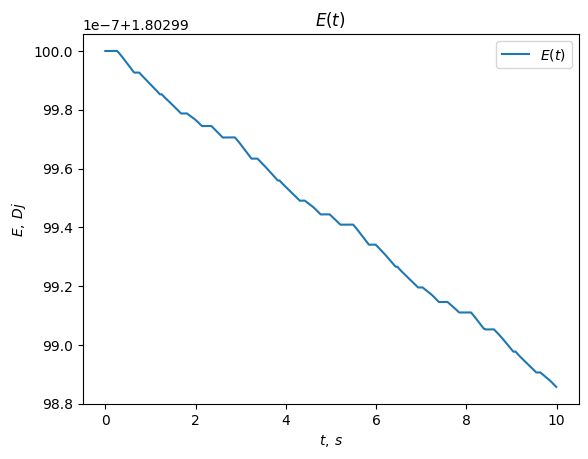

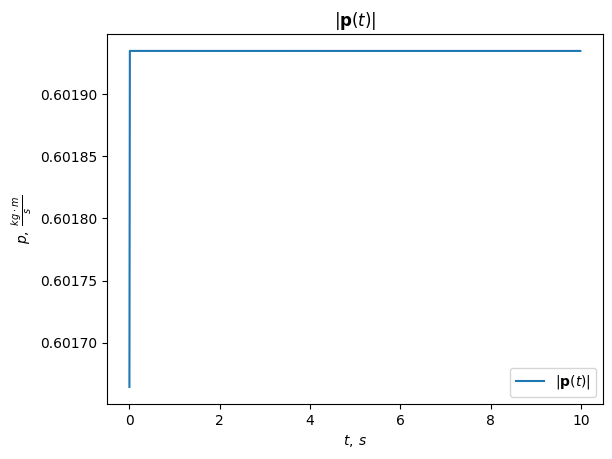

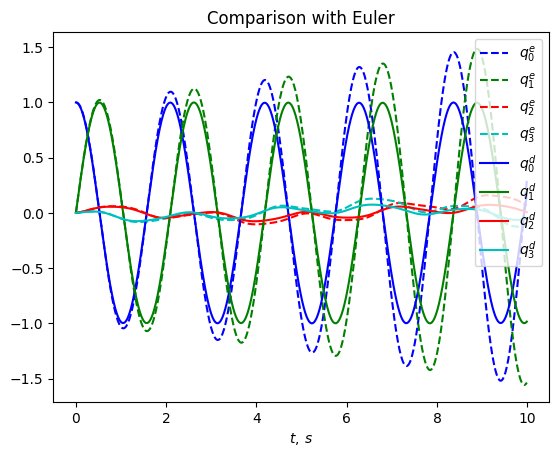

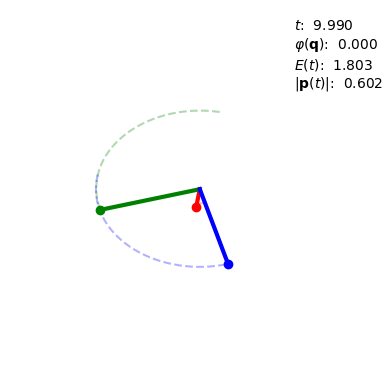

In [221]:
def plot_task_3(q_0: np.ndarray, omega_0: np.ndarray, t_span: np.ndarray, dt: float, title: str, rate: int = 10):
    p_0 = get_u(q_0).dot(get_q_dot(q_0, omega_0))
    # print(p_0, np.array([0, Ix * omega_0[0], Iy * omega_0[1], Iz * omega_0[2]]))
    # p_0 = np.array([0, Ix * omega_0[0], Iy * omega_0[1], Iz * omega_0[2]])
    qs, ps = simulate(q_0, p_0, t_span, dt)
    phis = [get_phi(_q) for _q in qs]

    energies = [
        0.5 * _p.dot(np.linalg.pinv(get_u(_q)).T.dot(_p)) for _p, _q in zip(ps, qs)
    ]
    ps = [np.linalg.norm(to_omega_momentum(_p, _q)) for _p, _q in zip(ps, qs)]

    plt.title(r'$|\varphi(\mathbf{q})|$')
    plt.plot(t_span, phis, label=r'$|\varphi(\mathbf{q})|$')
    plt.xlabel(r'$t, \: s$')
    plt.legend(loc='best')
    plt.show()

    plt.title(r'$E(t)$')
    plt.plot(t_span, energies, label=r'$E(t)$')
    plt.xlabel(r'$t, \: s$')
    plt.ylabel(r'$E, \: Dj$')
    plt.legend(loc='best')
    plt.show()

    plt.title(r'$|\mathbf{p}(t)|$')
    plt.plot(t_span, ps, label=r'$|\mathbf{p}(t)|$')
    plt.xlabel(r'$t, \: s$')
    plt.ylabel(r'$p, \: \frac{kg \cdot m}{s}$')
    plt.legend(loc='best')
    plt.show()

    euler = ForwardEuler(np.r_[q_0, omega_0], t_span, state_3)
    euler_sol = euler.solve()
    euler_qs = euler_sol[:, :4]

    plt.title('Comparison with Euler')
    plt.plot(t_span, euler_qs[:, 0], '--', label='$q_0^e$', color='b')
    plt.plot(t_span, euler_qs[:, 1], '--', label='$q_1^e$', color='g')
    plt.plot(t_span, euler_qs[:, 2], '--', label='$q_2^e$', color='r')
    plt.plot(t_span, euler_qs[:, 3], '--', label='$q_3^e$', color='c')
    plt.plot(t_span, qs[:, 0], label='$q_0^d$', color='b')
    plt.plot(t_span, qs[:, 1], label='$q_1^d$', color='g')
    plt.plot(t_span, qs[:, 2], label='$q_2^d$', color='r')
    plt.plot(t_span, qs[:, 3], label='$q_3^d$', color='c')
    plt.xlabel(r'$t, \: s$')
    plt.legend(loc='best')
    plt.show()

    timestamps = []
    rot_ms = []

    for k in range(len(t_span) // rate):
        k = k * rate
        timestamps.append(t_span[k])
        rot_ms.append(qt_rot(qs[k]))

    stats = [
        ['$t$', timestamps],
        [r'$\varphi(\mathbf{q})$', phis],
        [r'$E(t)$', energies],
        ['$|\mathbf{p}(t)|$', ps],
    ]

    rot_ms = np.array(rot_ms)
    visualize_rotation(rot_ms, title, stats=stats)

plot_task_3(np.array([1, 0, 0, 0]), np.array([6, 0.1, 0.1]), T_SPAN, DT, 'task_3_discrete_1', rate=1)

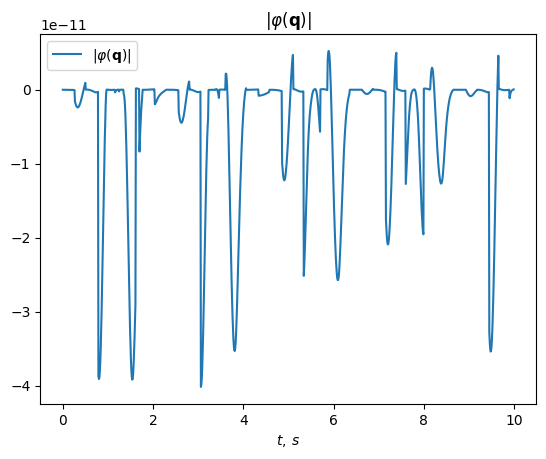

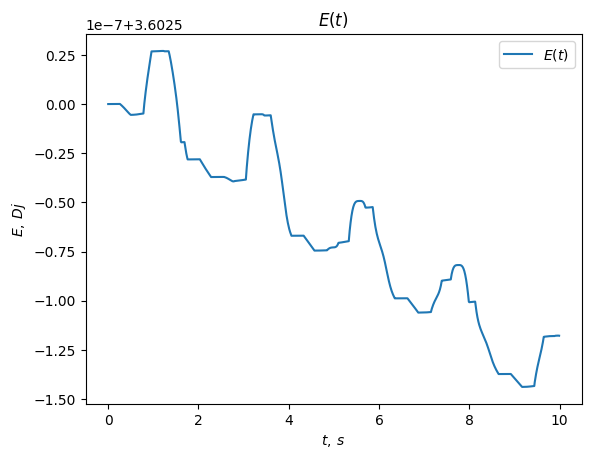

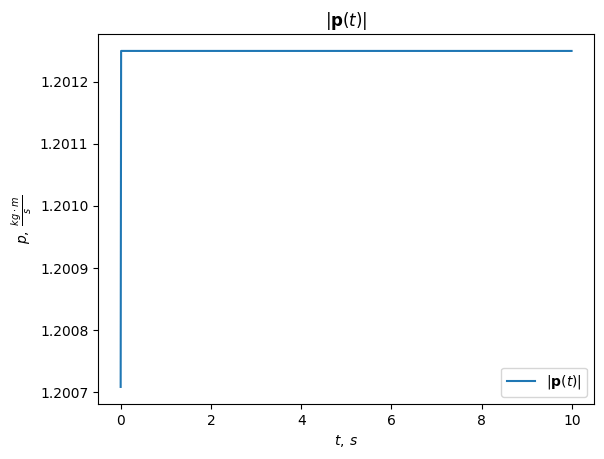

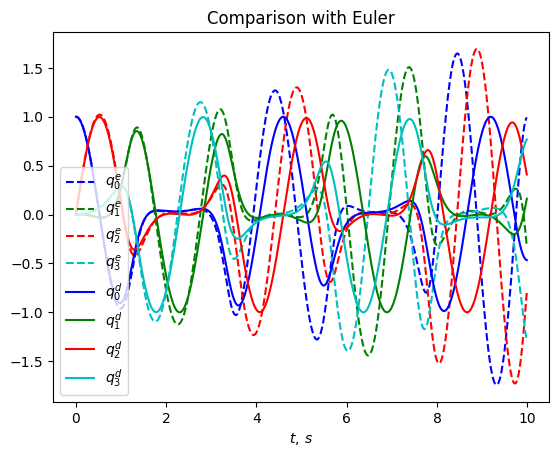

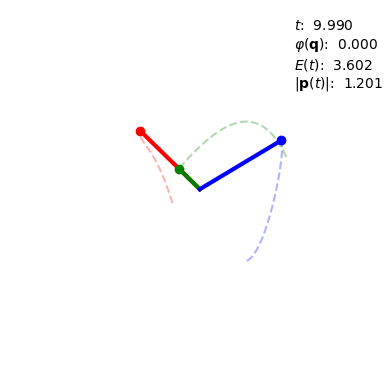

In [222]:
plot_task_3(np.array([1, 0, 0, 0]), np.array([0.1, 6, 0.1]), T_SPAN, DT, 'task_3_discrete_2', rate=1)

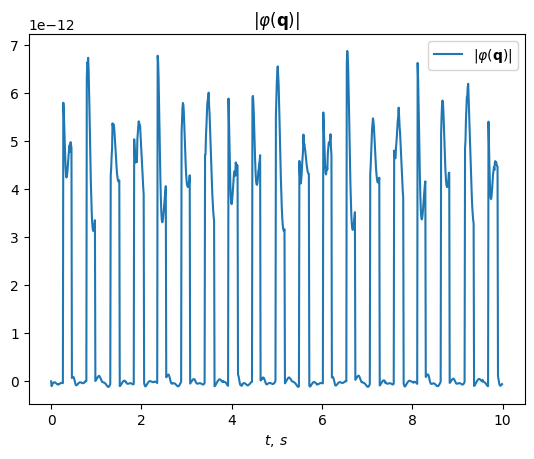

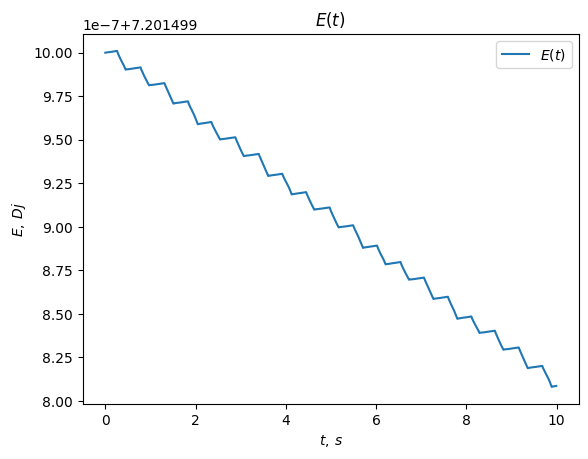

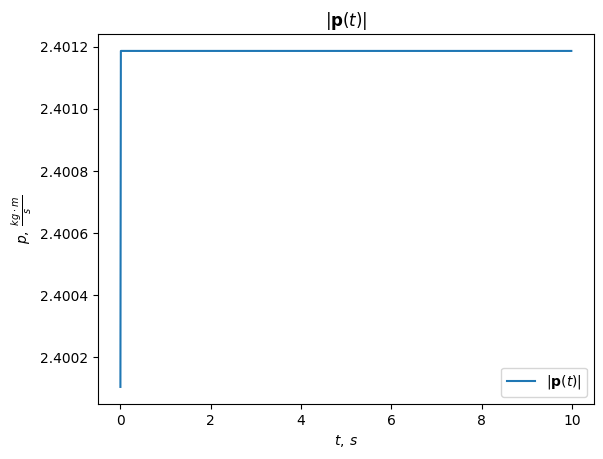

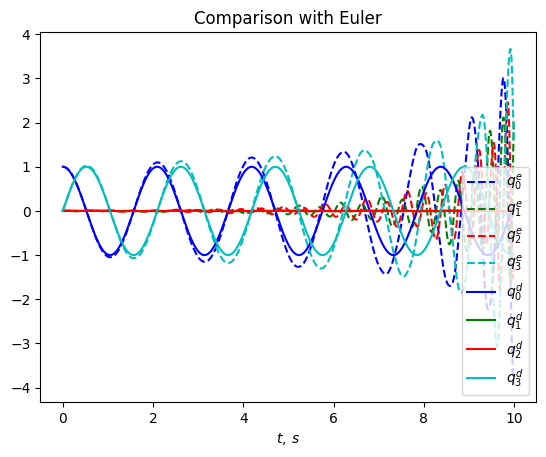

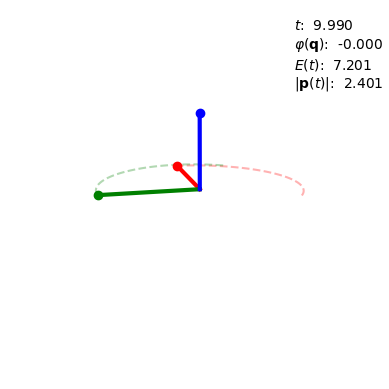

In [223]:
plot_task_3(np.array([1, 0, 0, 0]), np.array([0.1, 0.1, 6]), T_SPAN, DT, 'task_3_discrete_3', rate=1)